In [309]:
#Read in the data from the files.
from mnist import MNIST
import numpy as np
mndata = MNIST('../HW1/mnist')

trainData, trainLabel = mndata.load_training()

testData, testLabel = mndata.load_testing()

trainData = np.asarray(trainData)
testData = np.asarray(testData)
trainLabel = np.asarray(trainLabel)[:, np.newaxis]
testLabel = np.asarray(testLabel)[:, np.newaxis]

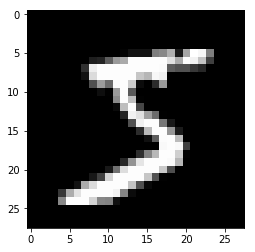

In [234]:
#Show a templete of digits.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time


img = np.reshape(trainData[0],(28,28))
plt.figure()
plt.imshow(img, cmap=cm.gray)
plt.show()

In [310]:
def FeatureBuilder(data):
    feat = []
    feat.append(1)
    for t in data:
        feat.append(t)
    return feat

In [313]:
xTrain = [FeatureBuilder(d) for d in np.asarray(trainData)]
xTest = [FeatureBuilder(d) for d in np.asarray(testData)]
# Process the range of pixel value to [-1..1]
xTrain = np.asarray(xTrain)
#xTrain = xTrain / 255.0
xTrain = xTrain / 127.5 - 1
yTrain = trainLabel

xTest = np.asarray(xTest)
#xTest = xTest / 255.0
xTest = xTest / 127.5 - 1
yTest = testLabel

# Logistic Regression via Gradient Descent

In [315]:
# Define data extraction function
def dataExtract(data, label, target1, target2):
    dataEx = []
    labelEx = []
    for x, y in zip(data, label):
        if y == target1:
            dataEx.append(x)
            labelEx.append(1)
        if y == target2:
            dataEx.append(x)
            labelEx.append(0)
    dataEx = np.asarray(dataEx)
    labelEx = np.expand_dims(np.asarray(labelEx),axis = 1)
    return dataEx, labelEx

In [316]:
xTrain28, yTrain28 = dataExtract(xTrain, yTrain, 2, 8)
xTest28, yTest28 = dataExtract(xTest, yTest, 2, 8)

In [323]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def calculateLossLR(data, label, weight):
    loss = -1.0 * np.sum(label * np.log(sigmoid(np.dot(data, weight)))\
                         + (1 - label) * np.log(1 - sigmoid(np.dot(data, weight))))
    loss = loss / len(data)
    return loss

def logisticRegression(trainD, trainL, lr = 1e-5, maxIter = 500, T = 500):
        
    validRate = int(len(trainD) * 9.0 / 10)
    
    validD = trainD[validRate:]
    validL = trainL[validRate:]
    
    trainDa = trainD[:validRate]
    trainLa = trainL[:validRate]
    
    w_0 = np.zeros((len(trainDa[0]), 1))
    it = 0
    while it <= maxIter:
        lr1 = lr / (1.0 + it / T)
        
        derE = np.sum((sigmoid(np.dot(trainDa, w_0)) - trainLa) \
                      * trainDa, axis = 0)[:, np.newaxis]
        w_0 -= lr1 * derE
        loss = calculateLossLR(validD, validL, w_0)
        if it % 100 == 0:
            print(loss)
        it += 1
    return w_0

In [331]:
weight = logisticRegression(xTrain28, yTrain28, 1e-5, 1000)

0.383240611826
0.0723836682338
0.0652990092467
0.0628444936198
0.0616605775118
0.0609581747702
0.0604797467051
0.0601232347087
0.0598415141021
0.0596099584993
0.0594143401529


In [332]:
def pecisionRate(data, label, weight):
    pred = sigmoid(np.dot(data, weight))
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    rate = 1.0 * np.sum([a == b for (a, b) in zip(pred, label)]) / len(label)
    return rate

In [333]:
acc = pecisionRate(xTest28, yTest28, weight)
acc

0.97856430707876374

In [372]:
def calculateLoss(data, label, weight, lam):
    a = data.dot(weight)
    y = np.exp(a) / np.sum(np.exp(a), axis=1)[:, np.newaxis]
    E = -1.0 * np.sum(label * np.log(y)) / len(data)
    C = np.sum(np.power(weight, 2))
    loss = E + lam * C
    return loss

def oneHot(label):
    labelHot = np.zeros((len(label),len(np.unique(label))))
    for i in range(len(label)):
        labelHot[i,label[i]] = 1
    return labelHot

def softmaxRegression(trainData, trainLabel, lr = 1e-4, maxIter = 500, T = 500, lam = 1e-3):
    
    classNum = len(np.unique(trainLabel))
    trainLabel = oneHot(trainLabel)
    
    validRate = int(len(trainData) * 9.0 / 10)
    
    trainD = trainData[:validRate]
    trainL = trainLabel[:validRate]
    
    validD = trainData[validRate:]
    validL = trainLabel[validRate:]
    
    w_0 = np.zeros((len(trainData[0]), classNum))
    it = 0
    
    while it <= maxIter:
        lr1 = lr / (1.0 + it / T)
        # Gradient Descent
        a = trainD.dot(w_0)
        y = np.exp(a) / np.sum(np.exp(a), axis=1)[:, np.newaxis]
        y = y - trainL
        derE = np.zeros((len(trainD[0]), classNum))
        for i in range(classNum):
            derE[:, i] = np.sum(trainD * y[:, i][:, np.newaxis], axis = 0)
        derC = 2 * np.sum(w_0)
        derJ = derE + lam * derC
        w_0 -= lr1 * derJ
        #w_0 -= lr1 * derE
        lossV = calculateLoss(validD, validL, w_0, lam)
        if it % 10 == 0:
            print (lossV)
        it += 1
    print ('done')
    return w_0

In [376]:
weight = softmaxRegression(xTrain, yTrain, 1e-5, 200, lam = 1e-3)

3.7378013867
85.5315202953
10.8417440244
4.96003225266
1.58018720758
3.44893965138
1.94464474507
1.79662866586
1.45443219833
0.870489048454
0.768208347182
0.7242238005
0.693224142045
0.68344304798
1.27664318122
0.940623563759
0.682497826065
0.60829154471
0.586596067811
0.569396946981
0.555059610065
done


In [377]:
def pecisionRate(data, label, weight):
    correct = 0
    for i in range(len(data)):
        a = data[i][np.newaxis,:].dot(weight)
        y = (np.exp(a) / np.sum(np.exp(a)))[0]
        prediction = np.where(y == np.max(y))[0][0]
        if label[i, prediction] == 1:
            correct += 1
    rate = 1.0 * correct / len(label)
    return rate

In [378]:
yTeHot = oneHot(yTest)
acc = pecisionRate(xTest, yTeHot, weight)
acc

0.9064